In [1]:
#pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
device = 'cpu'

data = pd.read_csv('pmsm_temperature_data.csv')
data.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


A continuación la explicación de los datos que conforman el dataset **Electric Motor Temperature** con origen en Kaggle y desarrollado por la Universidad de Paderborn y el profesor Dr. Ing Joachim Böcker de Power Electronics and Electrical Drives:
* **ambient**: Temperatura ambiental medida por un sensor termal localizado cerca del estator.
* **coolant**: Temperatura del liquido refrigerante. El motor es enfriado por agua. La medida es tomada en la salida.
* **u_d**: Voltaje en el componente d (d-component).
* **u_q**: Voltaje en el componente q (q-component).
* **motor_speed**: Velocidad del motor.
* **torque**: Torque inducido por la corriente.
* **i_d**: Corriente en el componente d (d-component).
* **i_q**: Corriente en el componente q (q-component).
* **pm**: Temperatura superficial del magneto permanente representando la temperatura del rotor. Este dato fue medido con un infrarojo.
* **stator_yoke**: Temperatura del yugo del estator medido con un sensor termal.
* **stator_winding**: Temperatura del viento en el estator medido con sensor termal.
* **stator_tooth**: Temperatura del diente del estator medido con un sensor térmico.
* **stator_yoke**: Temperatura del yugo del estator medido con un sensor termal.
* **profile_id**: Cada sesión de medición tiene un unico ID.

In [39]:
nans=pd.isnull(data).sum()
nans[nans>0]

Series([], dtype: int64)

In [28]:
nans

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

In [29]:
data

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245722,0.429853,1.018568,0.836084,0.494725,72
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013417,0.834438,0.494279,72
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666,72
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581,72


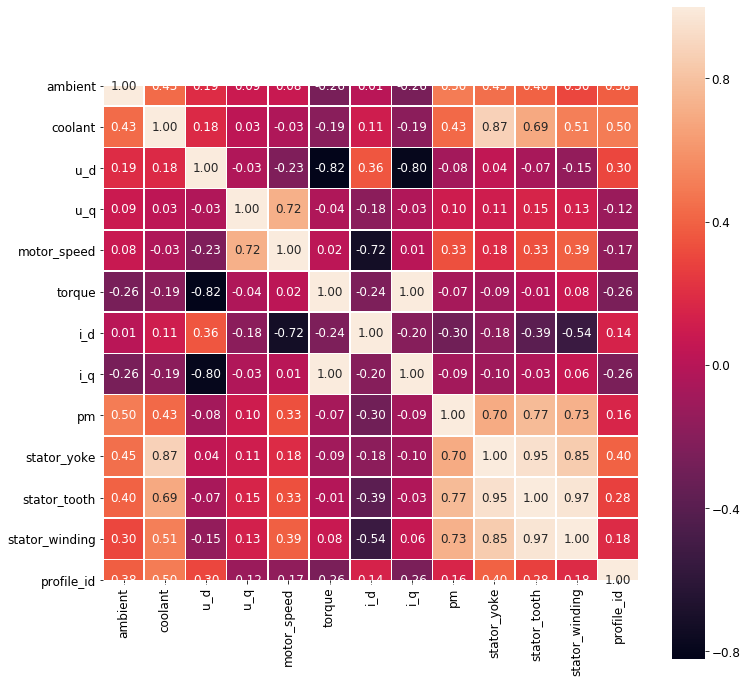

In [30]:
#correlation map
f,ax=plt.subplots(figsize=(12,12))
corr=data.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f',
            mask= np.zeros_like(corr,dtype=np.bool), 
            square=True, ax=ax)

plt.show()

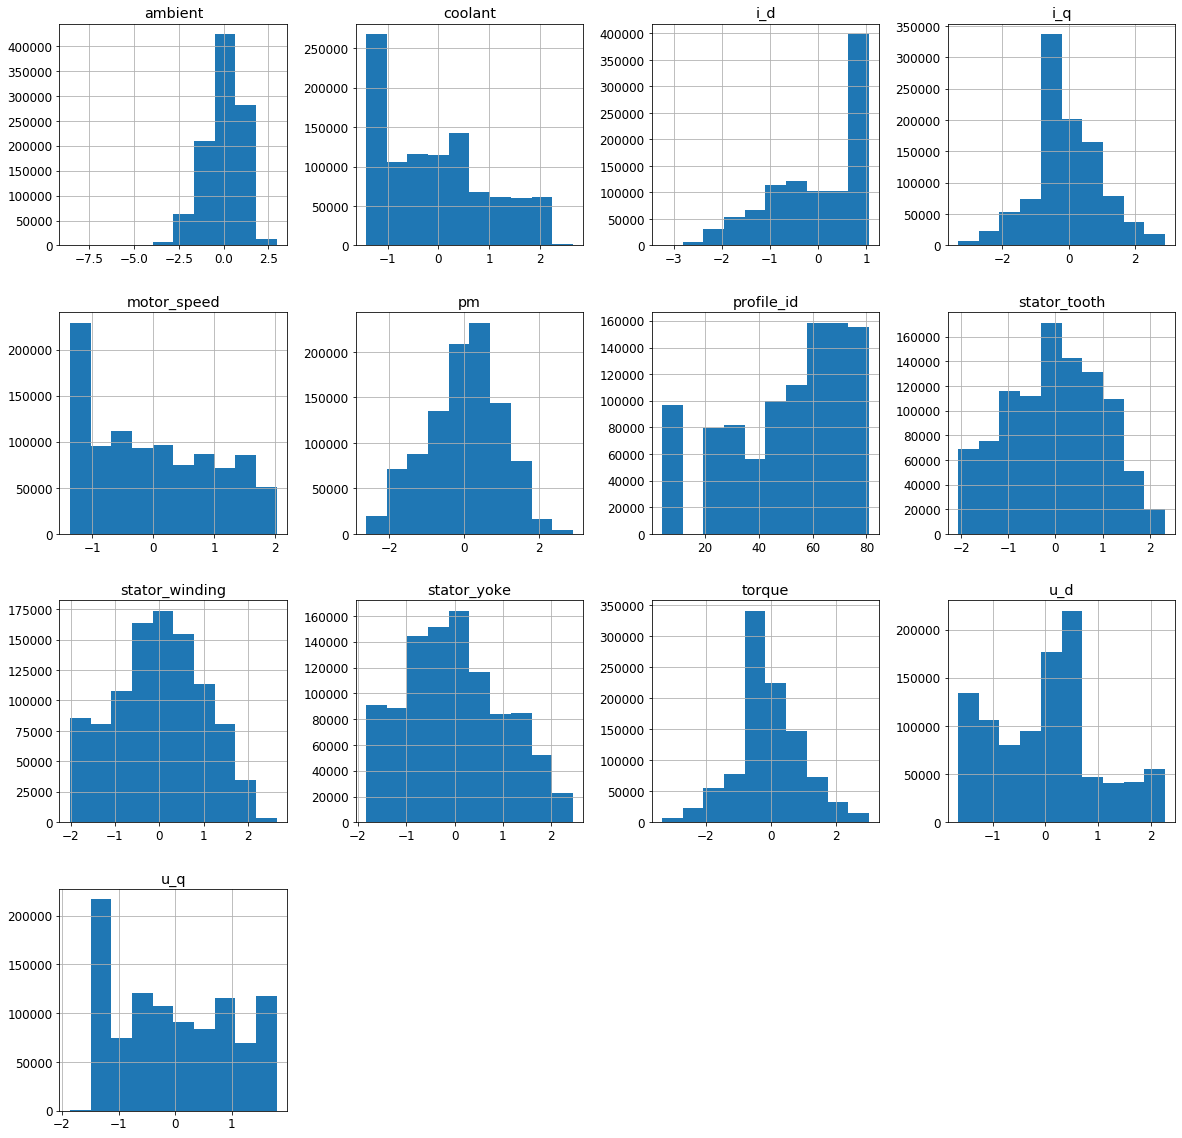

In [31]:
data.hist(figsize = (20,20))
plt.show()

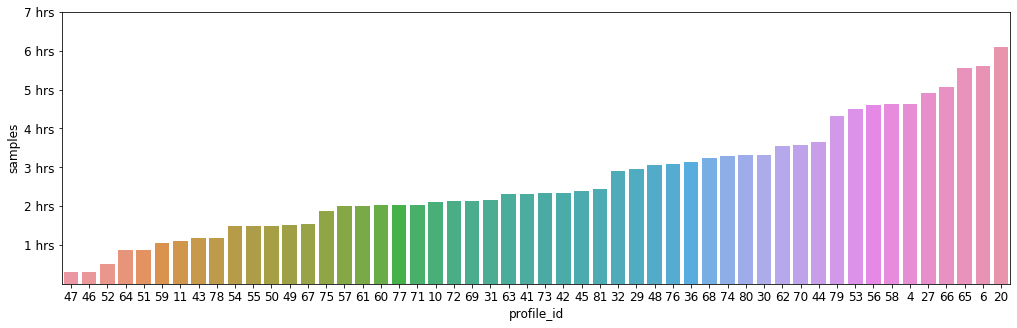

In [32]:
fig = plt.figure(figsize=(17, 5))
grpd = data.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)])

In [33]:
data = data.drop(columns=['profile_id'])
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


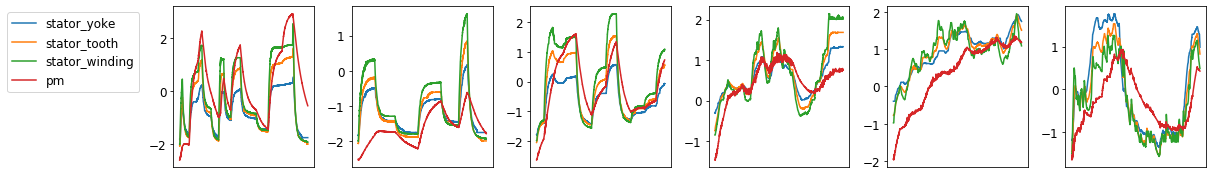

In [34]:
def pick_equidistant_elems(m, n):
    """De un conjunto de n elementos, escoger m que tengan una misma distancia unos de otros"""
    return [i*n//m + n//(2*m) for i in range(m)]

  
target_features = ['stator_yoke','stator_tooth', 'stator_winding', 'pm']
matplotlib.rcParams.update({'font.size': 12})
ids_to_plot = np.asarray(ordered_ids)[pick_equidistant_elems(6, len(ordered_ids))]
fig2 = plt.figure(figsize=(17, 10))
cols = len(ids_to_plot)
for i, (sess_id, _df) in enumerate([g for g in grpd if g[0] in ids_to_plot]):
    _df = _df.reset_index(drop=True)
    plt.subplot(4, cols, i+1)
    plt.xticks([])
    for target in target_features:
        plt.plot(_df[target], label=target)
    if i == 0:
        plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
    
plt.tight_layout()

Después de realizar el análisis anterior de los datos, se puede unificar variables que son redundantes en el modelo.

In [35]:
temp = data[['pm','stator_yoke','stator_tooth','stator_winding']]
torque = data[['torque','i_q','u_d']]
everything_else = data[['ambient','coolant','u_q','motor_speed','i_d']]

In [54]:
tempnulo=temp
tempnulo

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...
998065,0.429853,1.018568,0.836084,0.494725
998066,0.429751,1.013417,0.834438,0.494279
998067,0.429439,1.002906,0.833936,0.492666
998068,0.429558,0.999157,0.830504,0.490581


In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_temp = pca.fit_transform(temp)
temp_df = pd.DataFrame(data = pca_temp, columns = ['temp_1'])

pca = PCA(n_components=1)
pca_torque = pca.fit_transform(torque)
torque_df = pd.DataFrame(data = pca_torque, columns = ['torque_1'])

temporal = pd.concat([temp_df, torque_df], axis = 1)
temporal.head()

final=pd.concat([temporal, everything_else], axis=1)
final.describe()

,temp_1,torque_1,ambient,coolant,u_q,motor_speed,i_d
count,9.980700e+05,9.980700e+05,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-4.006821e-15,-7.952974e-15,-0.003905,0.004723,-0.005690,-0.006336,0.006043
std,1.865128e+00,1.653672e+00,0.993127,1.002423,1.002330,1.001229,0.998994
min,-4.212039e+00,-4.273946e+00,-8.573954,-1.429349,-1.861463,-1.371529,-3.245874
25%,-1.318927e+00,-1.228369e+00,-0.599385,-1.037925,-0.927390,-0.951892,-0.756296
50%,3.111943e-02,3.118333e-01,0.266157,-0.177187,-0.099818,-0.140246,0.213935
75%,1.406493e+00,4.873743e-01,0.686675,0.650709,0.852625,0.853584,1.013975
max,4.360209e+00,5.060004e+00,2.967117,2.649032,1.793498,2.024164,1.060937


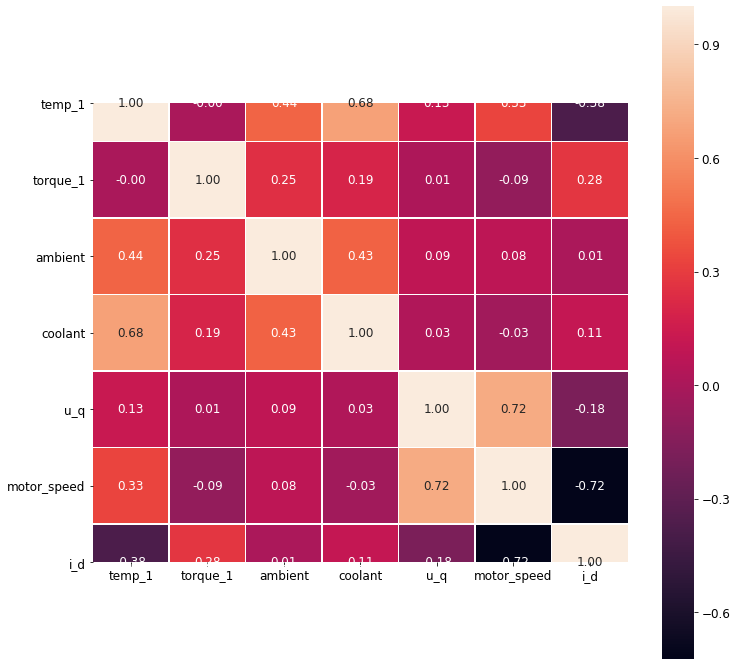

In [59]:
f,ax=plt.subplots(figsize=(12,12))
corr=final.corr()

sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', mask= np.zeros_like(corr,dtype=np.bool), 
            square=True, ax=ax)

plt.show()

In [60]:
df_x = final.drop(["temp_1", "torque_1", "u_q"],axis=1)
df_y = pd.DataFrame(final['temp_1']) #temp 1 es la variable dependiente
df_x.head()

,ambient,coolant,motor_speed,i_d
0,-0.752143,-1.118446,-1.222428,1.029572
1,-0.771263,-1.117021,-1.222429,1.029509
2,-0.782892,-1.116681,-1.222428,1.029448
3,-0.780935,-1.116764,-1.222430,1.032845
4,-0.774043,-1.116775,-1.222429,1.031807


In [61]:
df_y.head()

,temp_1
0,-4.183849
1,-4.182892
2,-4.182157
3,-4.181306
4,-4.181587


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [63]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_cached

xTrain, xTest, yTrain, yTest = train_test_split(df_x.to_numpy(), df_y.to_numpy(), test_size = 0.3, random_state = 0)

x_train = torch.FloatTensor(xTrain)
y_train = torch.FloatTensor(yTrain)
x_test = torch.FloatTensor(xTest)
y_test = torch.FloatTensor(yTest)
print(x_train.shape)

torch.Size([698649, 4])


In [65]:
from torch.optim.lr_scheduler import CyclicLR

In [71]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Feedforward, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size - 1)
    self.fc3 = torch.nn.Linear(self.hidden_size - 1, self.hidden_size - 1)
    self.fc4 = torch.nn.Linear(self.hidden_size - 1, self.hidden_size - 2)
    self.fc5 = torch.nn.Linear(self.hidden_size - 2, self.hidden_size - 3 )
    self.fc6 = torch.nn.Linear(self.hidden_size - 3, 1)
    self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):
    hidden = self.fc1(x)
    relu = self.relu(hidden)
    hidden2 = self.fc2(relu)
    relu2 = self.relu(hidden2)
    hidden3 = self.fc3(relu2)
    relu3 = self.relu(hidden3)
    hidden4 =  self.fc4(relu3)
    relu4 = self.relu(hidden4)
    hidden5 = self.fc5(relu4)
    relu5 = self.relu(hidden5)
    output = self.fc6(relu5)
    output = self.sigmoid(output)
    return output

def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform_(m.weight)#torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0.01)

#### Aplicando Stochastic Gradient Descent

In [69]:
def sgd(inputs, hidden_nodes, lr, momentum, epoch, x_train, y_train, x_test, y_test, batch_size):
  model = Feedforward(inputs, hidden_nodes)
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)
  losses = []
  model.train()

  for epoch in range(epoch):
    
    for batch in range(math.floor(x_train.shape[0] / batch_size)):
      optimizer.zero_grad()
      x_batch = x_train[batch*batch_size:batch*batch_size + batch_size, :]
      y_batch = y_train[batch*batch_size:batch*batch_size + batch_size]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      
      # Pase adelantado
      y_pred = model(x_batch)
      # Pérdida computacional
      loss = criterion(y_pred.squeeze(), y_batch)
      losses.append(loss)
      if epoch > 0 and epoch % 1000 == 0:
          print('Epoch {}: perdida entrenamiento: {}'.format(epoch, loss.item()))
      # Paso hacia atrás
      loss.backward()
      optimizer.step()

  print('**************************')
  model.eval()
  y_pred = model(x_test[0:batch_size, :].to(device))
  after_train = criterion(y_pred.squeeze(), y_test[0:batch_size].to(device).squeeze()) 
  print('Pérdida despues de Entrenar: ' , after_train.item())

  r_square = r2_score(y_test[0:batch_size, :], y_pred.cpu().detach().numpy().squeeze())
  print('R cuadrado: '+ str(r_square))

  return losses

In [72]:
losses = sgd(4, 6, 0.5, 0.9, 100, x_train, y_train, x_test, y_test, 1024)
print(losses[-1])

C:\Users\diego\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**************************
Pérdida despues de Entrenar:  3.572748899459839
R cuadrado: -0.00013402188238620383
tensor(3.4377, grad_fn=<MseLossBackward>)


#### Adam

In [74]:
def adam(inputs, hidden_nodes, epoch, x_train, y_train, x_test, y_test, batch_size):
  model = Feedforward(inputs, hidden_nodes)
  model.to(device)
  model.apply(init_weights)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())

  model.train()
  
  losses = []
  for epoch in range(epoch):
     for batch in range(math.floor(x_train.shape[0] / batch_size)):
      optimizer.zero_grad()
      x_batch = x_train[batch*batch_size:batch*batch_size + batch_size, :]
      y_batch = y_train[batch*batch_size:batch*batch_size + batch_size, :]
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      # Paso siguiente
      y_pred = model(x_batch)
      # Pérdida en el cálculo
      loss = criterion(y_pred.squeeze(), y_batch)
      losses.append(loss)
#       if epoch % 100 == 0:
#           print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      # Paso hacia atrás
      loss.backward()
      optimizer.step()

  print('**************************')
  model.eval()
  y_pred = model(x_test[0:batch_size, :].to(device))
  after_train = criterion(y_pred.squeeze(), y_test[0:batch_size].to(device).squeeze()) 
  print('Pérdida despues de Entrenar: ' , after_train.item())

  r_square = r2_score(y_test[0:batch_size, :], y_pred.cpu().detach().numpy().squeeze())
  print('R cuadrado: '+ str(r_square))

  return losses

In [75]:
losses = adam(4, 30, 100, x_train, y_train, x_test, y_test, 1024)
print(losses[-1])

C:\Users\diego\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**************************
Pérdida despues de Entrenar:  3.5727498531341553
R cuadrado: -0.00013427340749272432
tensor(3.4377, grad_fn=<MseLossBackward>)
